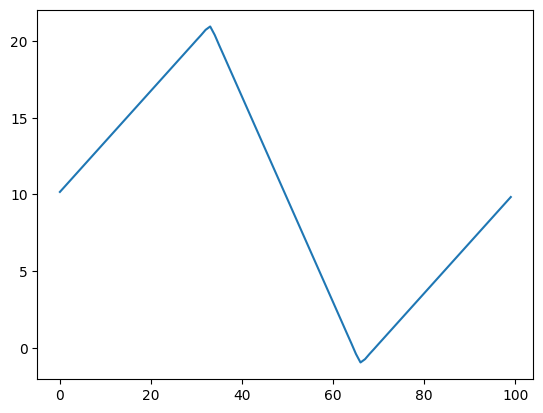

In [1]:
import numpy as np
from muFFT import FFT
import matplotlib.pyplot as plt

# PARAMETERS
length = 10
nb_points = 100 # number of grid points
avg_temp = 10   # average temperature
# set the sources and sinks
qs_val = np.zeros(nb_points)
qs_val[int(nb_points*1/3)] = 1
qs_val[int(nb_points*2/3)] = -1


# INITIALISE FIELDS
fft = FFT((nb_points, ), engine='pocketfft')
qs = fft.real_space_field('qs rfield')
qs_hat = fft.fourier_space_field('qs ffield')
t_hat = fft.fourier_space_field('temperature ffield', (1,))
result = fft.real_space_field('result rfield')
qs.p = qs_val
fft.fft(qs, qs_hat)

# calculate wavenumbers q for (q^2) in laplacian
wavenumber = fft.fftfreq[0].copy() * 2*np.pi
wavenumber[0] = 1 # prevent division by zero, set average temperature manually

# solve the equation for steady state (R=0)
t_hat.p = qs_hat.p / wavenumber**2 * fft.normalisation
t_hat.p[0] = avg_temp

# Perform an inverse FFT
fft.ifft(t_hat, result)

plt.plot(result.p )
plt.show()


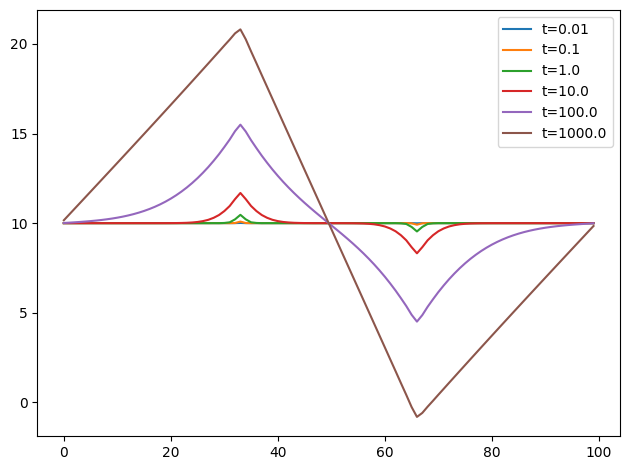

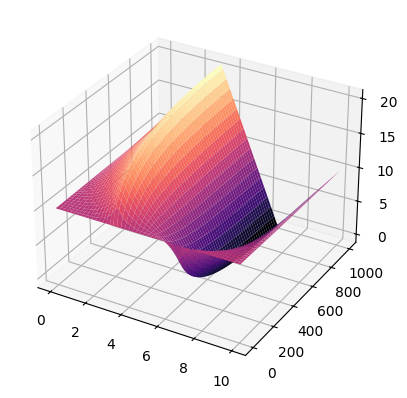

In [2]:

t = fft.real_space_field('temperature rfield')
t.p = np.ones(t.p.shape)*avg_temp
t_hat = fft.fourier_space_field('temperature ffield', (1,))
fft.fft(t, t_hat)
result = fft.real_space_field('result rfield')

dt = 0.01
t_total = 1000.
nb_timesteps = int((t_total+dt)/dt)
z_values_plot = np.zeros((nb_points, nb_timesteps))

t_hat_0 = t_hat.p[0]
for i in range(nb_timesteps):
  t_hat.p = t_hat.p + (-wavenumber**2 * t_hat.p + qs_hat.p) *dt 
  t_hat.p[0] = t_hat_0

  fft.ifft(t_hat, result)
  z_values_plot[:,i] = result.p * fft.normalisation

# regular plot in log 10 intervals
i=1
while i<nb_timesteps:
  plt.plot(z_values_plot[:,i-1], label="t="+str(i*dt))
  i*=10
plt.legend()
plt.tight_layout()
plt.show()

# surface plot of time evolution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x,y = (np.linspace(0, length, nb_points), np.linspace(0.0, t_total, nb_timesteps))
X, Y = np.meshgrid(x,y)
surf = ax.plot_surface(X,Y, z_values_plot.T,linewidth=0, antialiased=True, cmap=plt.colormaps["magma"]) #  
plt.show()

